In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import os
import admix_prs
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import admix

In [4]:
np.random.seed(1)
# target at [5%, 95%] interval
TARGET_QUANTILE = 0.05
TARGET_QUANTILE_Z = scipy.stats.norm.ppf(1 - TARGET_QUANTILE)

In [9]:
INFO_PATH = "/u/project/sgss/UKBB/PRS-RESEARCH/02-yi-simulate-prs/subcontinenal/meta/covariates.txt"
df_anc = pd.read_csv(INFO_PATH, sep="\t")
df_anc = df_anc.set_index("eid")

trait_li = ["bmi", "hdl_cholesterol", "height", "ldl_direct"]
prs_dict, pheno_dict = {}, {}
for trait in trait_li:
    df_prs = pd.read_csv(f"/u/project/sgss/UKBB/PRS-RESEARCH/03-kangcheng-real-prs/out/PREDICTION/{trait}.tsv.gz", sep="\t")
    df_prs["indiv"] = df_prs["indiv"].apply(lambda x: x.split("_")[0])
    df_prs = df_prs.set_index("indiv")
    df_prs["MEAN"] -= df_prs["MEAN"].mean()
    df_prs = df_prs.dropna()
    df_prs.index = df_prs.index.astype(int)
    df_prs["PHENO_STD"] = np.sqrt(df_prs["SD"] ** 2 + var_e)
    df_prs["PHENO"] = df_prs["MEAN"] + df_prs["PHENO_STD"]
    df_prs["PHENO_LOWER"] = df_prs["MEAN"] - df_prs["PHENO_STD"] * TARGET_QUANTILE_Z
    df_prs["PHENO_UPPER"] = df_prs["MEAN"] + df_prs["PHENO_STD"] * TARGET_QUANTILE_Z
    df_prs["PRS_LOWER"] = df_prs["QUANTILE_5"]
    df_prs["PRS_UPPER"] = df_prs["QUANTILE_95"]
    prs_dict[trait] = df_prs
    
    df_trait_pheno = pd.read_csv(f"/u/project/pasaniuc/kangchen/tmp/prs-1219/REAL-PHENO/{trait}.raw.pheno", sep="\t")
    df_trait_pheno.index = df_trait_pheno["FID"]
    df_trait_pheno = df_trait_pheno.drop(columns=["FID"])
    df_trait_pheno = df_trait_pheno.dropna()
    df_trait_pheno = df_trait_pheno.rename(columns={"PHENO": "REAL"})
    df_trait_pheno.index = df_trait_pheno.index.astype(int)
    df_trait_pheno["REAL"] = admix.data.quantile_normalize(df_trait_pheno["REAL"])
    pheno_dict[trait] = df_trait_pheno

In [12]:
df_anc

,sex,age,deprivation_index,ancestry,PC1,PC2,PC3,PC4,PC5,PC6,...,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,date,group
eid,,,,,,,,,,,,,,,,,,,,,
1000026,0,57,-2.418780,1001,-9.94105,3.05703,-0.466343,-2.08150,-7.125890,-1.990820,...,2.44748,5.399110,5.376850,1.606220,-1.688330,0.861698,1.120940,4.106990,50.875000,United Kingdom
1000032,1,64,-3.960050,1001,-14.61760,3.54024,-3.521440,6.75910,7.999590,-2.824470,...,6.67507,0.546660,2.803880,-3.477800,-1.108000,0.342568,-2.830270,4.273430,44.375000,United Kingdom
1000044,0,47,2.865800,1002,6.68544,-2.91200,13.416200,-45.25130,10.064700,-6.174340,...,0.30115,0.314391,1.766060,3.475320,0.889404,-1.718480,0.428843,0.203847,61.958333,Italy
1000058,1,53,4.651150,1001,-9.97432,2.29831,-1.265110,3.14470,0.931964,1.203180,...,3.91807,0.561904,0.987499,1.986780,-0.419901,5.392510,-0.000903,0.816695,55.041667,United Kingdom
1000060,0,62,-4.511300,1001,-13.55280,5.05130,-1.456260,-0.81878,-4.303490,-0.320742,...,-4.84984,0.186843,2.200240,-1.514600,-1.198240,-1.503960,-2.460590,-6.679310,45.875000,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026126,1,49,-2.261770,1001,-11.22710,4.09981,2.824300,-3.64909,-7.239380,0.755878,...,1.31627,-1.236570,-4.148300,-1.103140,1.091690,1.148640,-1.062070,2.146180,59.291667,United Kingdom
6026132,1,59,1.921320,1001,-14.37550,3.38334,-2.116290,2.92408,4.800640,1.401280,...,3.03595,-2.966240,-4.614100,1.813020,0.806913,9.534470,0.965536,-2.211800,49.041667,United Kingdom
6026144,1,41,-0.989482,1002,-13.48330,3.44693,-0.522458,5.80064,17.272800,-1.180140,...,-1.40233,-0.655608,-1.602630,-0.652331,0.633552,-3.373110,3.602030,-0.912842,68.791667,United Kingdom


In [13]:
trait = "height"
var_e = 0.5 # hsq = 0.5

In [14]:
df_info = pd.merge(
    prs_dict[trait][["MEAN", "SD", "PHENO", "PHENO_STD", "PHENO_LOWER", "PHENO_UPPER", "PRS_LOWER", "PRS_UPPER"]], 
    df_anc[["sex", "age", "PC1", "PC2", "group"]], 
    left_index=True, 
    right_index=True
)

df_info = pd.merge(
    df_info, 
    pheno_dict[trait]["REAL"], 
    left_index=True, 
    right_index=True
)

df_admix = df_info.loc[df_info["group"]=="Caribbean"]
df_admix["PC1_Q"] = admix_prs.make_levels(df_admix, stratify_col="PC1", n_level=5)
df_admix["PC2_Q"] = admix_prs.make_levels(df_admix, stratify_col="PC2", n_level=5)
df_admix["AGE_Q"] = admix_prs.make_levels(df_admix, stratify_col="age", n_level=5)
df_admix

<ipython-input-14-19e307521150>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admix["PC1_Q"] = admix_prs.make_levels(df_admix, stratify_col="PC1", n_level=5)
<ipython-input-14-19e307521150>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admix["PC2_Q"] = admix_prs.make_levels(df_admix, stratify_col="PC2", n_level=5)
<ipython-input-14-19e307521150>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,MEAN,SD,PHENO,PHENO_STD,PHENO_LOWER,PHENO_UPPER,PRS_LOWER,PRS_UPPER,sex,age,PC1,PC2,group,REAL,PC1_Q,PC2_Q,AGE_Q
2516559,-0.508938,0.53323,0.508084,1.017022,-2.181791,1.163915,-1.00491,0.70708,0,46,326.792,62.4450,Caribbean,-0.394391,"(310.627, 336.452]","(27.348, 63.393]","(45.0, 49.0]"
2900473,0.361602,0.55485,1.390125,1.028522,-1.330167,2.053371,-0.19826,1.57551,0,46,369.861,68.7891,Caribbean,0.656854,"(364.371, 374.936]","(66.732, 69.347]","(45.0, 49.0]"
4736406,-0.254468,0.52652,0.759052,1.013520,-1.921560,1.412624,-0.78003,0.94283,1,50,349.910,65.9163,Caribbean,1.235733,"(336.452, 352.278]","(63.393, 66.732]","(49.0, 54.0]"
5482221,-0.823348,0.56022,0.208081,1.031429,-2.519898,0.873202,-1.38790,0.44339,0,68,346.732,64.5957,Caribbean,-0.617540,"(336.452, 352.278]","(63.393, 66.732]","(61.0, 70.0]"
2001699,0.136902,0.53812,1.156497,1.019595,-1.540182,1.813986,-0.36441,1.40233,1,56,334.719,67.3946,Caribbean,1.068338,"(310.627, 336.452]","(66.732, 69.347]","(54.0, 61.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989335,-0.350618,0.53994,0.669938,1.020556,-2.029284,1.328048,-0.81305,0.88840,0,53,332.310,63.1114,Caribbean,0.005440,"(310.627, 336.452]","(27.348, 63.393]","(49.0, 54.0]"
3371009,-0.613748,0.54081,0.407269,1.021017,-2.293171,1.065675,-1.07192,0.68138,0,40,317.165,62.1423,Caribbean,-0.186919,"(310.627, 336.452]","(27.348, 63.393]","(39.999, 45.0]"
3404205,-0.698958,0.52701,0.314817,1.013775,-2.366469,0.968553,-1.23162,0.53571,1,57,312.449,63.7949,Caribbean,-1.110919,"(310.627, 336.452]","(63.393, 66.732]","(54.0, 61.0]"
1243144,-0.388308,0.56512,0.645791,1.034099,-2.089249,1.312633,-0.90556,0.91272,1,41,385.070,72.0722,Caribbean,0.371913,"(374.936, 385.07]","(71.458, 78.484]","(39.999, 45.0]"


## Case 1: phenotype mean as a function of covariates

2022-01-27 21:45.08 [info     ] Regress pred_col=PRED against mean_adjust_cols=['PC1'] fitted with `calibrate_index` individuals
2022-01-27 21:45.08 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                   REAL   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.988
Date:                Thu, 27 Jan 2022   Prob (F-statistic):            0.00832
Time:                        21:45:08   Log-Likelihood:                -163.22
No. Observations:                 121   AIC:                             332.4
Df Residuals:                     118   BIC:                             340.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    st

/u/home/z/ziqixu09/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,r2,coverage,length
PC1_Q,,,
"(310.627, 336.452]",0.061008,0.936475,3.361956
"(336.452, 352.278]",0.070543,0.946612,3.375229
"(352.278, 364.371]",0.020167,0.938398,3.384571
"(364.371, 374.936]",0.019389,0.928131,3.393319
"(374.936, 385.07]",0.055028,0.930328,3.400811


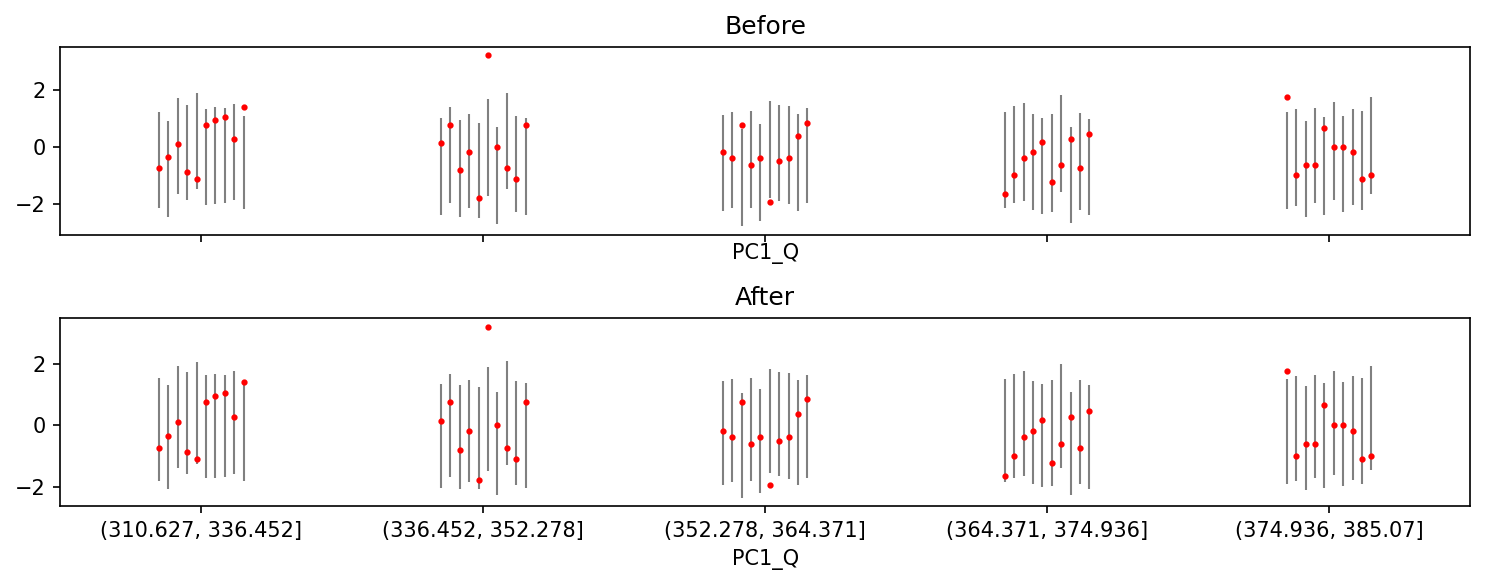

In [15]:
np.random.seed(1)
# use 5% of the individual for calibration
calibrate_idx = np.random.choice(df_admix.index, size=int(len(df_admix) * 0.05), replace=False)

# perform calibration
df1_calibrated = admix_prs.calibrate_pred(
    df_admix,
    true_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    mean_adjust_cols=["PC1"],
)
df1_calibrated[["REAL", "PC1_Q"]] = df_admix[["REAL", "PC1_Q"]].reindex(df1_calibrated.index)

display(
    admix_prs.evaluate(
        df1_calibrated,
        true_col="REAL",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="PC1_Q",
    )
)

# visualize before and after
fig, axes = plt.subplots(figsize=(10, 4), dpi=150, nrows=2, sharex=True)
admix_prs.plot_calibration(
    df=df_admix,
    y_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="PC1_Q",
    ax=axes[0],
)

admix_prs.plot_calibration(
    df=df1_calibrated,
    y_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="PC1_Q",
    ax=axes[1],
)

axes[0].set_title("Before")
axes[1].set_title("After")
fig.tight_layout()

#### Not much difference before and after calibration

## Case 2: variance as a function of covariates

In [16]:
# perform calibration with TARGET_QUANTILE adjusted
df2_calibrated = admix_prs.calibrate_pred(
    df_admix,
    true_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    calibrate_idx=calibrate_idx,
    method="scale",
    quantile_adjust_cols=["PC1"],
    q=TARGET_QUANTILE,
)
df2_calibrated[["REAL", "PC1_Q"]] = df_admix[["REAL", "PC1_Q"]].reindex(
    df2_calibrated.index
)

2022-01-27 21:45.14 [info     ] Regress pred_col=PRED against mean_adjust_cols=[] fitted with `calibrate_index` individuals
2022-01-27 21:45.14 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                   REAL   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     10.01
Date:                Thu, 27 Jan 2022   Prob (F-statistic):            0.00198
Time:                        21:45:14   Log-Likelihood:                -163.24
No. Observations:                 121   AIC:                             330.5
Df Residuals:                     119   BIC:                             336.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err

/u/home/z/ziqixu09/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,r2,coverage,length
PC1_Q,,,
"(310.627, 336.452]",0.060881,0.924180,3.361956
"(336.452, 352.278]",0.071092,0.934292,3.375229
"(352.278, 364.371]",0.020165,0.895277,3.384571
"(364.371, 374.936]",0.019640,0.917864,3.393319
"(374.936, 385.07]",0.054928,0.895492,3.400811


,r2,coverage,length
PC1_Q,,,
"(310.627, 336.452]",0.060881,0.940574,3.469570
"(336.452, 352.278]",0.071092,0.946612,3.341258
"(352.278, 364.371]",0.020165,0.926078,3.246713
"(364.371, 374.936]",0.019640,0.915811,3.171487
"(374.936, 385.07]",0.054928,0.897541,3.110461


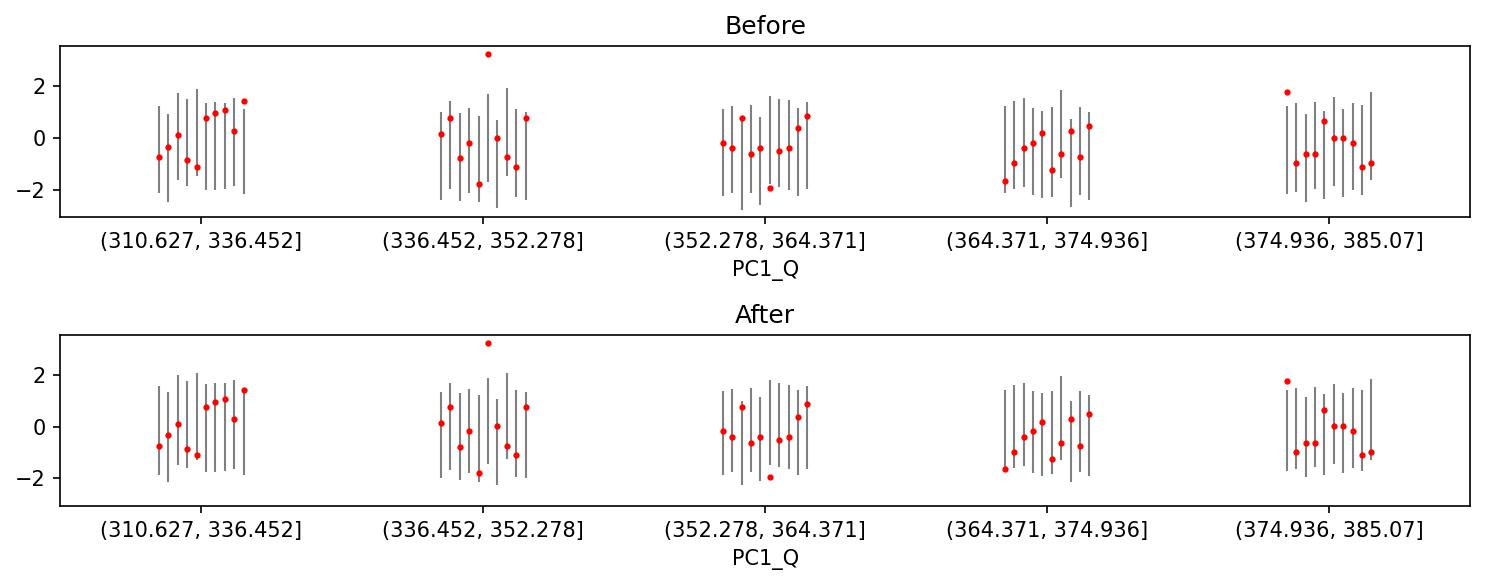

In [17]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=150, nrows=2, sharey=True)
admix_prs.plot_calibration(
    df=df_admix,
    y_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="PC1_Q",
    n=10,
    ax=axes[0],
)
axes[0].set_title("Before")
display(
    admix_prs.evaluate(
        df=df_admix,
        true_col="REAL",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="PC1_Q",
    )
)

admix_prs.plot_calibration(
    df=df2_calibrated,
    y_col="REAL",
    lower_col="PHENO_LOWER",
    upper_col="PHENO_UPPER",
    group_col="PC1_Q",
    n=10,
    ax=axes[1],
)
axes[1].set_title("After")

display(
    admix_prs.evaluate(
        df=df2_calibrated,
        true_col="REAL",
        lower_col="PHENO_LOWER",
        upper_col="PHENO_UPPER",
        group_col="PC1_Q",
    )
)

fig.tight_layout()